In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


Data successfully read from 5PAISA.csv.


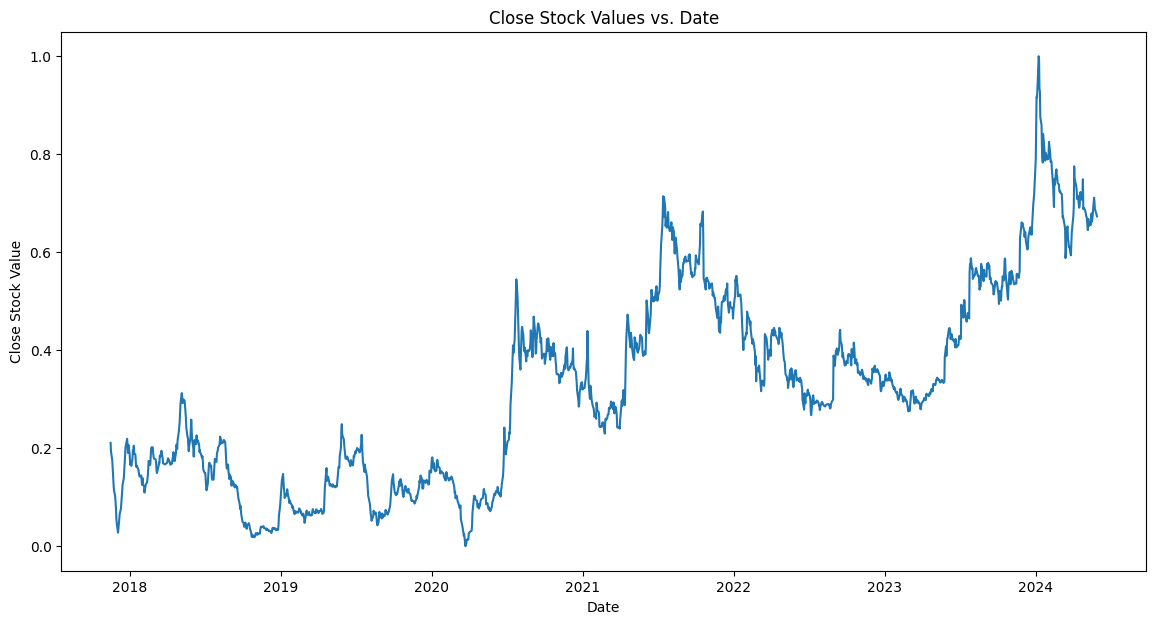

Epoch 1/50
40/40 - 1s - loss: 0.0365 - 1s/epoch - 30ms/step
Epoch 2/50
40/40 - 0s - loss: 0.0020 - 168ms/epoch - 4ms/step
Epoch 3/50
40/40 - 0s - loss: 9.9355e-04 - 165ms/epoch - 4ms/step
Epoch 4/50
40/40 - 0s - loss: 8.8398e-04 - 164ms/epoch - 4ms/step
Epoch 5/50
40/40 - 0s - loss: 8.5425e-04 - 157ms/epoch - 4ms/step
Epoch 6/50
40/40 - 0s - loss: 8.0719e-04 - 160ms/epoch - 4ms/step
Epoch 7/50
40/40 - 0s - loss: 7.8280e-04 - 153ms/epoch - 4ms/step
Epoch 8/50
40/40 - 0s - loss: 7.6529e-04 - 176ms/epoch - 4ms/step
Epoch 9/50
40/40 - 0s - loss: 7.4457e-04 - 140ms/epoch - 4ms/step
Epoch 10/50
40/40 - 0s - loss: 7.2992e-04 - 136ms/epoch - 3ms/step
Epoch 11/50
40/40 - 0s - loss: 7.4470e-04 - 145ms/epoch - 4ms/step
Epoch 12/50
40/40 - 0s - loss: 7.0975e-04 - 143ms/epoch - 4ms/step
Epoch 13/50
40/40 - 0s - loss: 6.9503e-04 - 145ms/epoch - 4ms/step
Epoch 14/50
40/40 - 0s - loss: 6.5715e-04 - 140ms/epoch - 4ms/step
Epoch 15/50
40/40 - 0s - loss: 6.3783e-04 - 155ms/epoch - 4ms/step
Epoch 16/50
40

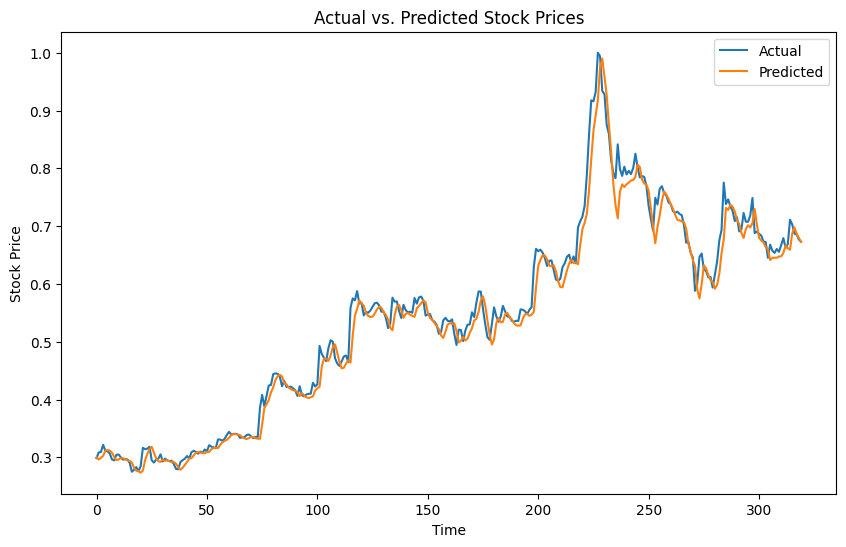

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

class StockPricePredictor:
    def __init__(self):
        self.dataframe = pd.DataFrame([])
        self.model = None

    def read(self, file_name: str):
        """Reads a CSV file into the dataframe."""
        if os.path.exists(file_name):
            self.dataframe = pd.read_csv(file_name)
            print(f"Data successfully read from {file_name}.")
        else:
            print(f"Error: The file {file_name} does not exist.")

    def preprocess_data(self, target_column='Close'):
        """Preprocesses the data for LSTM."""
        # Drop rows with missing values
        self.dataframe.dropna(inplace=True)

        # Normalize data
        scaler = MinMaxScaler()
        self.dataframe[target_column] = scaler.fit_transform(self.dataframe[[target_column]])

    def create_sequences(self, sequence_length=10, target_column='Close'):
        """Creates sequences for LSTM training."""
        sequences = []
        targets = []

        for i in range(len(self.dataframe) - sequence_length):
            sequence = self.dataframe.iloc[i : i + sequence_length][target_column]
            target = self.dataframe.iloc[i + sequence_length][target_column]
            sequences.append(sequence.values)
            targets.append(target)

        return np.array(sequences), np.array(targets)

    def build_model(self, sequence_length, feature_dim=1):
        """Builds the LSTM model."""
        self.model = Sequential([
            LSTM(50, activation='relu', input_shape=(sequence_length, feature_dim)),
            Dense(1)
        ])
        self.model.compile(optimizer='adam', loss='mse')

    def train_model(self, X_train, y_train, epochs=50, batch_size=32):
        """Trains the LSTM model."""
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
        return history

    def evaluate_model(self, X_test, y_test):
        """Evaluates the model on test data."""
        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        mae = self.calculate_mae(y_test, y_pred)
        r2 = self.calculate_r2_score(y_test, y_pred)
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R² Score: {r2}")
        return mse, rmse, mae, r2

    def calculate_mae(self, y_true, y_pred):
        """Calculates the Mean Absolute Error (MAE)."""
        return mean_absolute_error(y_true, y_pred)

    def calculate_r2_score(self, y_true, y_pred):
        """Calculates the R² score."""
        return r2_score(y_true, y_pred)

    def visualize(self, y_label):
        """Plots graph for stock values vs. date."""
        if 'Date' in self.dataframe.columns and y_label in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            sns.lineplot(data=self.dataframe, x='Date', y=y_label)
            plt.title(f'{y_label} Stock Values vs. Date')
            plt.xlabel('Date')
            plt.ylabel(f'{y_label} Stock Value')
            plt.show()
        else:
            print(f"Dataframe does not contain 'Date' and '{y_label}' columns.")

if __name__ == "__main__":
    predictor = StockPricePredictor()
    predictor.read("5PAISA.csv")  # Replace "your_dataset.csv" with your dataset file
    # Visualize initial dataset
    predictor.preprocess_data()
    predictor.visualize('Close')
    sequence_length = 10  # Define sequence length
    sequences, targets = predictor.create_sequences(sequence_length=sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, shuffle=False)
    X_train = X_train.reshape((len(X_train), sequence_length, 1))
    X_test = X_test.reshape((len(X_test), sequence_length, 1))
    predictor.build_model(sequence_length)
    history = predictor.train_model(X_train, y_train)



    # Perform predictions on the test data
    y_pred = predictor.model.predict(X_test)

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('Actual vs. Predicted Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


In [6]:
# Evaluate the model
mse, rmse, mae, r2 = predictor.evaluate_model(X_test, y_test)

10/10 [==============================] - 0s 3ms/step
Mean Squared Error (MSE): 0.0006463252150387174
Root Mean Squared Error (RMSE): 0.025422926956562602
Mean Absolute Error (MAE): 0.016397738046727936
R² Score: 0.9773179644853625
